# 1.1 Setting up the system for OpenMM (NaCl)

## Imports

In [3]:
## import required packages
import numpy as np
import matplotlib.pyplot as plt
import openmm.app as omm_app
import openmm as omm
import openmm.unit as unit
from tqdm.notebook import tqdm_notebook
import mdtraj

### Aims of this Notebook

This is an example notebook on how to set up a simulation system under the OpenMM suite from given CHARMM-GUI input topology and parameter files.

You will learn: 
1. Read in topology files (CHARMM psf and pdb) for a simulation
2. Read in the set of CHARMM parameters provided
3. Create and save the OpenMM system for simulation. 
4. Add a custom bias with a harmonic potential 

## Introduction

### Simulating NaCl in water

For the purpose of this workshop, we use standard parameters for Na+ Cl- complex from a PDB crystal structure, solvated the system and generated the necessary files for simulation using Charmm-GUI (topology and parameters which can be found under the **/toppar/** folder). We will be using Charmm36m as our Force Field. If you are interested on generating your own parameters for your system using CHARMM-GUI you can find videos/demos and help [here](https://www.charmm-gui.org/?doc=demo).

We will be sampling the dissociation of NaCl in water and will try to reconstruct the free energy profile from the resulting simulations. In order to sample more efficiently we will use the umbrella sampling method to bias the distance between the ionic complex.  

**Our simulated system looks like this:**

<center>
<img src="images/solvated_system.png" alt="NaCl" width="500"/>
</center>

------

## Hands-on Code

### System creation

We first import the necessary psf/pdb files with the topology info to be able to look up the atom parameters on the force field.

In [8]:
psf_file = 'toppar/step3_input.psf' #Path
pdb_file = 'toppar/step3_input.pdb' #Path

OpenMM has specific functions that read in whatever is necessary from the files:

In [9]:
psf = omm_app.CharmmPsfFile(psf_file)
pdb = omm_app.PDBFile(pdb_file)

From the **/toppar/** folder we read in as well the parameter file with the info for our 2 ions (Na and Cl)

In [10]:
params = omm_app.CharmmParameterSet('toppar/toppar_water_ions.str')

Once everything necessary is in, we can create the system to simulate in OpenMM

In [11]:
## Create an OpenMM system
system = psf.createSystem(params)

### Defining the biasing potential

Now that we have our system we can add our custom bias to it.

In this case since we want to quickly see the dissociation of NaCl, for that, we will be biasing the distance between our two complexed ions. 

The most suitable bias for separating them would be a harmonic biasing potential. All we need to do is tell OpenMM the formula of the biasing potential and the degree of dredom we want to add the biasing potential to, the formula would look like: 

$$
  U_{i} = k_{i}(r - r_{o})^2
$$

In [12]:
## add a harmonic biasing potential on butane dihedral to the OpenMM system

#Define the equation
bias_bond = omm.CustomBondForce("0.5*k*(r-r0)^2")

#Set parameters
bias_bond.addGlobalParameter("k", 1.0)
bias_bond.addGlobalParameter("r0", 0.0) # Initial value of the distance

#Define the bond
bias_bond.addBond(0, 1) #Here you would have to put the atoms you will be adding the bond to

#We add it to the system 
system.addForce(bias_bond)

9

### Saving the system for the next step

Now that all is set up, we can save the file in a readble format. This will be in an XML formated text file, which can be used or re-read at any point later. You can open the file to see how the information is structured for yourself. 

In [13]:
## save the OpenMM system
with open("output_files/NaCl_solvated_system", 'w') as file_handle:
    file_handle.write(omm.XmlSerializer.serialize(system))

-------

## Optional tasks

We recommend if time allows, or at home, to try the following:


# 1.2 Running Umbrella Sampling on NaCl

### Aims of this Notebook

The aim of this notebook is to refresh how Umbrella Sampling works, what is needed to run it, and how to run it on the OpenMM framework. 

You will learn: 
1. Read in a previously created OpenMM system for simulation.
2. Set up the simulation parameters (Temperature, step size, friction, etc.).
3. Set up the umbrella centers across our reaction coordinate, with a defined force constant.
4. Run minimization/equilibration/production on each of the umbrellas. 

## Introduction

In **umbrella sampling**, the reaction coordinate (RC) which we want to sample fir is split into multiple windows and in each window, the RC (an atomic distance in our NaCl example) is restrained around each centre using the harmonic biasing potential. We will run simulations in each window sequentially, but of course they can run in parallel in your typical workstation. 

<center>
<img src="images/US.jpg" alt="NaCl" width="500"/>
</center>

**Note:** From this production, the data we will get will be **biased**. in order to be able to get back any kinetics or a correct free energy profile, we will need to unbias it. Which is explained in part 1.4

-------

## Hands-on Code

### Setting up the OpenMM context for simulation

To run our simulations we need to construct an OpenMM **context**, which needs a **system**, an **integrator** and a **platform**. Here we will use Langevin Dynamics for NVP ensemble simulation. The platform specifies on what kind of hardware we will run the simulations. 

In [14]:
## reading in the OpenMM system we created
with open("output_files/NaCl_solvated_system", 'r') as file_handle:
    xml = file_handle.read()
system = omm.XmlSerializer.deserialize(xml)

We state the platform here by using the string that corresponds.The CPU option should work on every computer, but if you can, try out CUDA or OpenCL for GPU speeds .

In [16]:
#Setting up the platform

# platform = omm.Platform.getPlatformByName('CUDA') # If you have GPU try this
# platform = omm.Platform.getPlatformByName('OpenCL') # Or this one, if the preivous does not work
platform = omm.Platform.getPlatformByName('CPU') # Try first using CUDA or OpenCL it is way faster

Now we set up all simulation-related parameters to ready up the context for our simulations

In [17]:
#### setup an OpenMM context

T = 298.15  ## temperature
fricCoef = 10 ## friction coefficient 
stepsize = 2  ## integration step size

integrator = omm.LangevinIntegrator(T*unit.kelvin, #Desired Integrator
                                    fricCoef/unit.picoseconds,
                                    stepsize*unit.femtoseconds) 
## construct an OpenMM context
context = omm.Context(system, integrator, platform)

### Placing the umbrellas 

We will place the different umbrella centers in geometrically spaced points on the log scale, this means having more points at the beggining and less at the end. In this case, we did this to better sample the transition state (TS) of our NaCl dissociation. However, the umbrellas could also be placed equidistantly. 

In [18]:
M = 10 # M centers of harmonic biasing potentials
start = 0.25 #First center (in nm)
end = 0.7 #Last center (in nm)

#Setting the centers for the umbrellas we'll use 
#umbrella_centers = np.geomspace(start, end, M, endpoint=False)
umbrella_centers = np.linspace(start, end, M, endpoint=False)

#We will save the centers in a .csv for when we need to check it
np.savetxt("output_files/bias.csv", umbrella_centers, delimiter = ",")

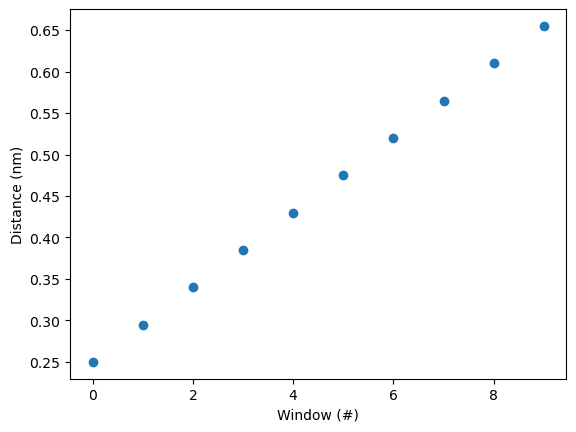

In [19]:
#Here you can plot at which distance each umbrella will be placed for each window
plt.plot(range(M), umbrella_centers, "o")
plt.ylabel("Distance (nm)")
plt.xlabel("Window (#)")
plt.savefig("images/geom_spaced_windows.png")

The points in the plot show at which distance each of the potentials is going to be placed. 

Now that the centers for the harmonic biasing potentials are defined, let's give the force constant a value for biasing the Na-Cl distance. 

In [20]:
# set force constant K for the biasing potential. 
# the unit here is kJ*mol^{-1}*nm^{-2}, which is the default unit used in OpenMM
K = 25000   # This is like 60 Kcal/mol
context.setParameter("k", K)

### Running the umbrella sampling

For running the simulations we will have to create a loop iterating the umbrellas by window (M), each configuration is minimized and equilibrated with the biasing potential and after that they are sampled and saved. 

In [15]:
import time
#The main loop to run umbrella sampling window by window
st = time.time()

#We will start from the PDB positions, so we need to load them again
#FOr saving the trajectories (.dcd ) in the correct topology we have to load them again
pdb_file = 'toppar/step3_input.pdb' #Path
psf_file = 'toppar/step3_input.psf' #Path
psf = omm_app.CharmmPsfFile(psf_file)
pdb = omm_app.PDBFile(pdb_file)

for window in range(M):
    s = time.time()
    print(f"Sampling at window: {window+1} out of {M}")
    
    # Set the center of the biasing potential for each window
    context.setParameter("r0", umbrella_centers[window])

    # Minimizing step 
    context.setPositions(pdb.positions)
    state = context.getState(getEnergy = True)
    energy = state.getPotentialEnergy()
    
    for i in tqdm_notebook(range(50), desc="Minimization Win {}".format(window+1)):
        omm.LocalEnergyMinimizer_minimize(context, 1, 20)
        state = context.getState(getEnergy = True)
        energy = state.getPotentialEnergy()
        
    print("Minimization in:", str(time.time() - s), "seconds")
    s = time.time()
    
    #Initial equilibration step
    integrator.step(500)
    
    print("Equilibration in:", str(time.time() - s), "seconds")
    s = time.time()

    #Sampling production. trajectories are saved in dcd files
    #file_handle = open(f"trajectories/traj_{window+1}_US_test.dcd", 'bw')
    file_handle = open(f"trajectories/long_traj/traj_win{window+1}_US.dcd", 'bw')
    dcd_file = omm_app.dcdfile.DCDFile(file_handle, psf.topology, dt = stepsize)
    
    for i in tqdm_notebook(range(1000), desc="Production"):
        integrator.step(100)
        state = context.getState(getPositions = True)
        positions = state.getPositions()
        dcd_file.writeModel(positions)
    file_handle.close()
    
    print("Production Run done in:", str(time.time() - s), "seconds")

Sampling at window: 1 out of 10


Minimization Win 1:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

Once the simulations have finished, we will have the corresponding trajectories in the **/trajectories/** folder for further analysis. Our next step is to calculate the RC obtained for each window.


-------

## Optional tasks


We recommend if time allows, or at home, to try the following:
- Try changing the number of umbrellas. How does it affect the obtained free energy profile?. ***Answer:*** A very small number of umbrellas will make your windows very spread and sample very little, whereas having too many umbrellas is computationally expensive.  
- Try also changing to linearly spaced windows (np.linspace). How is the sampling affecting the free energy profile?. ***Answer:*** Having an even sampling is helpful to easily sample the whole space, but sometimes a part can be more valuable than the rest and you might want to place more umbrellas. 
- Try modifying the force constant (K) to different values. How does it affects the sampling?.  ***Answer:*** High values will restrict the sampling to a very limited area, thus having no overlap between windows. A very low value will allow the windows to sample all configurations with too much overlap between the windows. 

# 1.3 Computing the biased CVs

### Aims of this Notebook

The aim of this notebook is to show how to easily fetch your RC from your resulting trajectories. We will be using mdtraj for this. 

You will learn: 
1. Calculate interatomic distances on mdtraj for your trajectories
2. Visualize the distances from the trajectories
3. Assess the overlapping of the different windows. 
4. Plot a simple histogram of the sampled biased data. 

## Introduction

After running the umbrella sampling on the NaCl complex we will have to calculate their distance at each of the windows/trajectories generated in order to reconstruct the free energy profile of the dissociation in water. In our case the reaction coordinate (RC) of the process is the interatomic distance between Na and Cl. For this we will use the mdtraj module which quickly loads the trajectory and calculates the distances for the atoms we specify.

<center>
<img src="images/dissociation.png" alt="NaCl" width="500"/>
</center>

-------

## Hands-on Code

### Loading trajectory and calculating distances

In order for mdtraj to calculate the distances we need to specify the topology for the .dcd file we saved. Additionally we will have to provide the atom index for the atoms we want to calculate the distance of. In our case 0 and 1 (python indexing based) are the relevant atoms. Then we will save the data in a .csv file for later analysis with the unbiasing tools to recover the profiles. 

In [21]:
#We need to load the topology so mdtraj knows what is what
topology = mdtraj.load_psf('toppar/step3_input.psf')

#Depending on the number of umbrellas we used we will have the same trajectories
all_dists = []
for window in range(M):
    #traj = mdtraj.load_dcd(f"trajectories/traj_{window+1}_US_test.dcd", topology)
    traj = mdtraj.load_dcd(f"trajectories/long_traj/traj_win{window+1}_US.dcd", topology) #WARNING! Uncomment in case you could not run the umbrellas
    dist = mdtraj.compute_distances(traj, [[0, 1]]) #Calculate distance
    np.savetxt(f"output_files/dist_win_{window+1}.csv", dist, fmt = "%.5f", delimiter = ",") # Save them for later analysis
    all_dists.append(dist.T[0]) #Append to the list 
    
all_dists = np.array(all_dists)*10 #We multiply by 10 so it's in Angstroms when we plot them

After calculating the distances, we'll make a few checks to see if the sampled datapoints are correct and if they sample the space.

Text(0.5, 0, 'Steps')

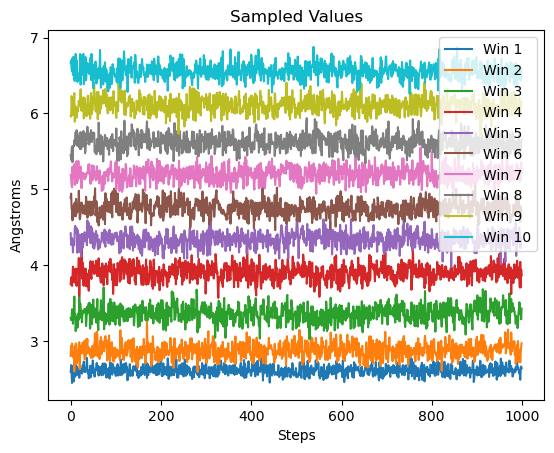

In [22]:
plt.title("Sampled Values")
for window in range(M):
    plt.plot(all_dists[window], label=f"Win {window+1}")
plt.legend()
plt.ylabel("Angstroms")
plt.xlabel("Steps")

As seen previously the windows sample throughout the RC space, from 2Å up to 7Å the endpoint of our umbrella centers. We see some overlapping, but we want to see how well the windows overlap, otherwise the space in between could not be sampled properly. 

Text(0.5, 0, 'Distance in Angstroms')

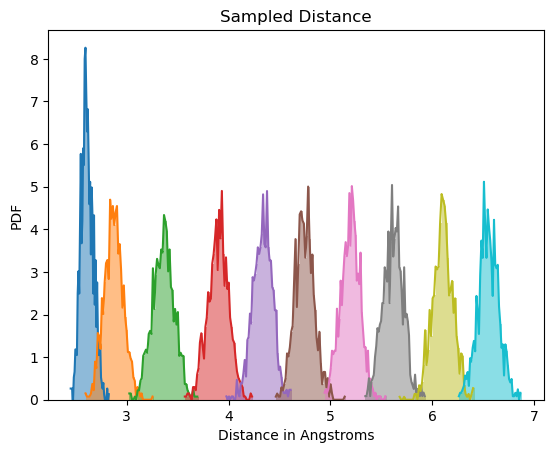

In [23]:
plt.title("Sampled Distance")
for n, dist in enumerate(all_dists):
    counts, bins, _ = plt.hist(dist, bins=50, density=True, alpha=0.5, color=f"C{n}")
    plt.plot(bins[:-1], counts, c=f"C{n}")
plt.ylabel("PDF")
plt.xlabel("Distance in Angstroms")

You can nicely see how each umbrella window has sampled a region of the RC and you see more centers have been placed between 2 Å and 4 Å, which is the region where the energy barrier of the dissociation can be found. We can plot the resulting sampled histogram for all trajectories to see how its profile looks like

Text(0.5, 0, 'Distance in Angstroms')

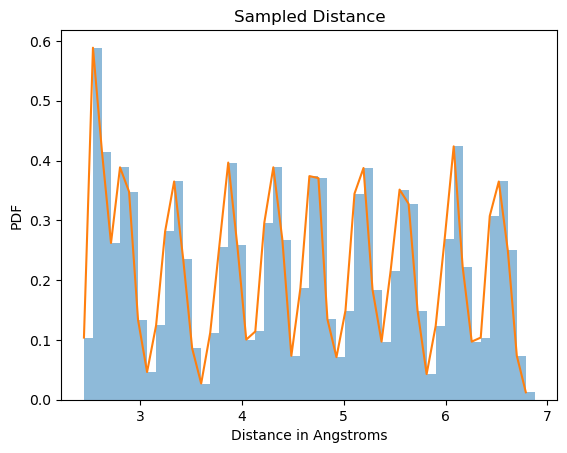

In [24]:
plt.title("Sampled Distance")
counts, bins, _ = plt.hist(np.concatenate(all_dists), bins=50, density=True, alpha=0.5)
plt.plot(bins[:-1], counts)
plt.ylabel("PDF")
plt.xlabel("Distance in Angstroms")

If the data were to be unbiased, we could have tried to simply construct the profile from the resulting histogram. As you see, the profile resembles the one of a dissociation, we did sample throughout the RC, but even the umbrellas can be seen from here. 

-----

## Optional tasks

We recommend if time allows, or at home, to try the following:
- Try generating the histograms with less data using all_dists[start:end] i.e. all_dists[0:500] or striding the data all_dists[::10]. 

# 1.4 Unbiasing the data

### Aims of this Notebook

The aim of this notebook is to teach you how to unbias the obtained data from the umbrella sampling trajectories and how to succesfully reconstruct the free energy profile for the dissociation of NaCl. 

You will learn: 
1. How to read in the obtained distances
2. How to calculate the bias that was applied on the trajectories by the biasing harmonic potential
4. How to prepare the data for unbiasing. 
3. How to recover the dissociation free energy profile with the Weighted Histogram Analysis Method (WHAM) and the Multistate Bennett Acceptance Ratio (MBAR). 

## Introduction

In [25]:
# read distance values from the umbrella sampling
dists = []
for window in range(M):
    dist = np.loadtxt(f"output_files/dist_win_{window+1}.csv", delimiter = ",")
    dists.append(dist*10) # We convert them to Angstroms

In [26]:
from src.wham import WHAM
dist = np.array(dists)
w = WHAM(".")
w.skip = 10
w.KbT = 0.001987204259 * T
w.data = dist.reshape((dist.shape[0], dist.shape[1], 1))
w.k_val = np.ones((dist.shape[0], 1)) * K / 418.4
w.constr_val = umbrella_centers.reshape(10,1)*10  # We convert them to Angstroms
w.converge(0.0001)
w.project_1d([1], 50)  # create a nice one, this also plots the contribution from each simulation

0.2
0.029873234219054474
0.028540368357594596
0.02733024741376998
0.02622470150300528
0.02520887011504236
0.02427051793240176
0.02339950957041062
0.022587401838175286
0.021827124132349773
0.021112725747416128
0.02043917455529315
0.01980219550896445
0.0191981402938593
0.018623881536191378
0.01807672651218062
0.01755434644494236
0.01705471833512151
0.01657607692411661
0.01611687488904573
0.015675749754748558
0.015251496309173163
0.014843043544311263
0.014449435331006233
0.01406981418387343
0.013703407590688221
0.01334951647549354
0.013007505441139822
0.012676794499067223
0.012356852044698052
0.012047188877908233
0.011747353102058544
0.01145692576273638
0.011175517110401989
0.010902763390107428
0.010638324077089312
0.010381879490245716
0.010133128726308782
0.009891787866585733
0.00965758841581632
0.009430275938900445
0.009209608866701302
0.008995357446514918
0.00878730281651341
0.008585236186752332
0.008388958111818945
0.008198277842537571
0.008013012746048154
0.007832987785063361
0.00765

/home/berta/PycharmProjects/enhanced-sampling-workshop-2022/Day1/1.Umbrella_Sampling_NaCl/src/wham.py:144: RuntimeWarning: divide by zero encountered in log
  self.rUepPerSim = -self.KbT * np.log(PpS) - valu


-2.705601943036392

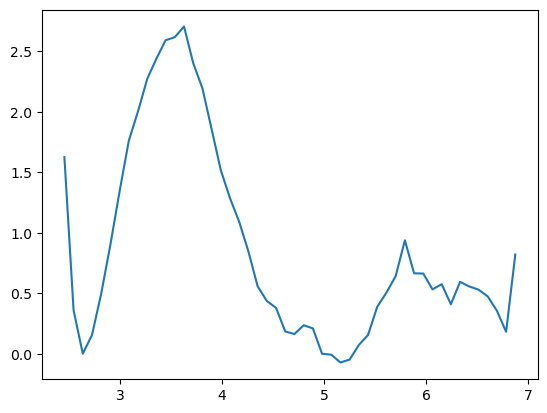

In [22]:
plt.plot(w.qspace12, w.rUep)

In [28]:
from src.dham import DHAM

In [29]:
d = DHAM()
d.data = all_dists
d.KbT = 0.001987204259 * T
d.k_val = np.ones(dist.shape[0]) * K / 418.4
d.constr_val = umbrella_centers * 10

Degree of symmetry: 0.8958221913997269


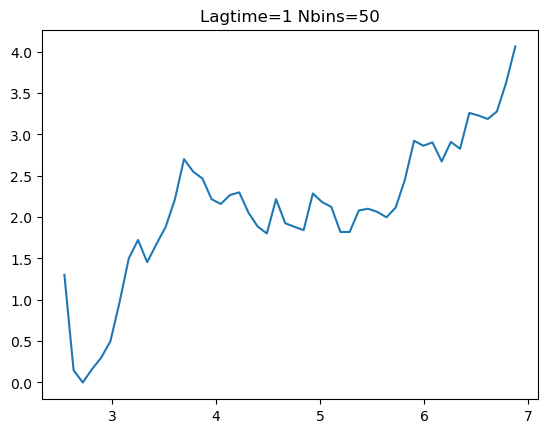

In [32]:
for l in [1]:
    for n in [50]:
        d.lagtime = l
        d.numbins = n
        d.run(biased=True)